In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [8]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

In [9]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [10]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")
pd.Series(dtype='float64')
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [12]:
train_df, test_df = train_test_split(
    all_df,
    train_size=0.8,
    shuffle=True,
    random_state=1
)

In [13]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [15]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

cnnmodel = tf.keras.Model(inputs=inputs, outputs=outputs)

cnnmodel.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(cnnmodel.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [16]:
cnn_history = cnnmodel.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
800/800 [==============================] - 187s 221ms/step - loss: 0.4129 - accuracy: 0.8318 - val_loss: 0.1933 - val_accuracy: 0.9648
Epoch 2/100
800/800 [==============================] - 46s 58ms/step - loss: 0.1255 - accuracy: 0.9639 - val_loss: 0.1003 - val_accuracy: 0.9670
Epoch 3/100
800/800 [==============================] - 46s 57ms/step - loss: 0.0851 - accuracy: 0.9729 - val_loss: 0.0832 - val_accuracy: 0.9716
Epoch 4/100
800/800 [==============================] - 47s 59ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.0737 - val_accuracy: 0.9780
Epoch 5/100
800/800 [==============================] - 49s 61ms/step - loss: 0.0701 - accuracy: 0.9772 - val_loss: 0.0648 - val_accuracy: 0.9806
Epoch 6/100
800/800 [==============================] - 46s 58ms/step - loss: 0.0638 - accuracy: 0.9800 - val_loss: 0.0652 - val_accuracy: 0.9802
Epoch 7/100
800/800 [==============================] - 48s 59ms/step - loss: 0.0635 - accuracy: 0.9805 - val_loss: 0.0611 - val_

In [17]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"], digits=4)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.05573
Test Accuracy: 98.40%
250/250 [==============================] - 11s 43ms/step


/tmp/ipykernel_31/2578638514.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


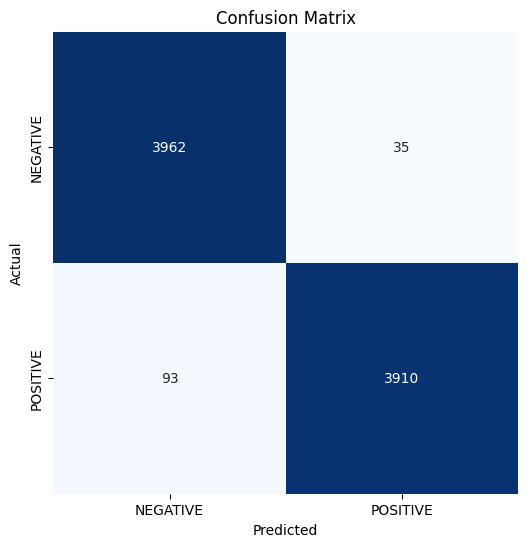

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE     0.9771    0.9912    0.9841      3997
    POSITIVE     0.9911    0.9768    0.9839      4003

    accuracy                         0.9840      8000
   macro avg     0.9841    0.9840    0.9840      8000
weighted avg     0.9841    0.9840    0.9840      8000



In [18]:
evaluate_model(cnnmodel, test_data)

In [20]:
cnnmodel.predict(test_data)

250/250 [==============================] - 12s 47ms/step


array([[0.00595515],
       [0.04721408],
       [0.00508388],
       ...,
       [1.        ],
       [0.00611439],
       [0.00573914]], dtype=float32)

In [21]:
cnnmodel.save("detection_model1.h5")


In [22]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/kaggle/input/test-img/Cracked-Concrete-Foundation.jpg')
pred = cnnmodel.predict(image)


if pred < 0.5:
    print("No Crack")
else:
    print("Crack")
    

1/1 [==============================] - 0s 115ms/step
Crack
